In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf

def load_data_for_modeling():
    data= yf.download('SPY', period='10y', progress=False, auto_adjust=True)

    new_cols= []
    if isinstance(data.columns, pd.MultiIndex) or any(isinstance(c, tuple) for c in data.columns):
        new_cols= [col[0] if isinstance(col, tuple) else col for col in data.columns]
    else:
        new_cols= data.columns.tolist()
    new_cols= [str(col).replace(' ', '_').capitalize() for col in new_cols]
    data.columns= new_cols


    close_col= 'Close'
    volume_col= 'Volume' if 'Volume' in data.columns else None

    if close_col not in data.columns:
        raise ValueError("Could not find 'Close' price column")

    features= pd.DataFrame(index=data.index)
    features['returns']= data[close_col].pct_change()
    # momentum
    features['momentum_5d']= data[close_col].pct_change(5)
    features['momentum_21d']= data[close_col].pct_change(21)
    features['momentum_50d']= data[close_col].pct_change(50)
    features['momentum_200d']= data[close_col].pct_change(200)
    # volatility
    features['volatility_5d']= features['returns'].rolling(5).std()
    features['volatility_21d']= features['returns'].rolling(21).std()
    features['volatility_50d']= features['returns'].rolling(50).std()
    features['volatility_200d']= features['returns'].rolling(200).std()
    # moving averages
    ma_5 = data[close_col].rolling(5).mean()
    ma_21 = data[close_col].rolling(21).mean()
    ma_50 = data[close_col].rolling(50).mean()
    ma_200 = data[close_col].rolling(200).mean()
    features['MA_5_21_ratio']= ma_5 / ma_21
    features['MA_21_50_ratio']= ma_21 / ma_50
    features['MA_50_200_ratio']= ma_50 / ma_200
    # volume
    if volume_col:
        features['volume_ratio']= (data[volume_col] /
                                   data[volume_col].rolling(21).mean())
    # target
    features['target']= features['returns'].shift(-1)

    # drop NaNs
    features_clean= features.iloc[200:-1].copy()

    return features_clean

features= load_data_for_modeling()
print(f"working with {len(features)} data points")

working with 2314 data points


In [7]:
# proper time-series split (no shuffling)
split_idx= int(0.7 * len(features))
train= features.iloc[:split_idx]
test= features.iloc[split_idx:]

print(f"\ntraining set: {len(train)} samples")
print(f"test set: {len(test)} samples")


feature_cols= [
    'momentum_5d', 'momentum_21d', 'momentum_50d', 'momentum_200d',
    'volatility_5d', 'volatility_21d', 'volatility_50d', 'volatility_200d',
    'MA_5_21_ratio', 'MA_21_50_ratio', 'MA_50_200_ratio',
    'volume_ratio'
]

feature_cols = [col for col in feature_cols if col in features.columns]

print(f"\nusing features for LR model: {feature_cols}")

X_train, X_test= train[feature_cols], test[feature_cols]
y_train, y_test= train['target'], test['target']

lr_model= LinearRegression()
lr_model.fit(X_train, y_train)

print("\nlinear model trained")
print("model coefficients:")
for feat, coef in zip(feature_cols, lr_model.coef_):
    print(f"  {feat}: {coef:.6f}")
print(f"model intercept: {lr_model.intercept_:.6f}")


training set: 1619 samples
test set: 695 samples

using features for LR model: ['momentum_5d', 'momentum_21d', 'momentum_50d', 'momentum_200d', 'volatility_5d', 'volatility_21d', 'volatility_50d', 'volatility_200d', 'MA_5_21_ratio', 'MA_21_50_ratio', 'MA_50_200_ratio', 'volume_ratio']

linear model trained
model coefficients:
  momentum_5d: -0.043232
  momentum_21d: 0.008430
  momentum_50d: -0.004378
  momentum_200d: 0.009392
  volatility_5d: -0.444011
  volatility_21d: 0.169431
  volatility_50d: 0.049471
  volatility_200d: 0.242840
  MA_5_21_ratio: -0.072966
  MA_21_50_ratio: -0.050614
  MA_50_200_ratio: -0.017266
  volume_ratio: 0.000113
model intercept: 0.140907


In [8]:
# make predictions
train_pred= lr_model.predict(X_train)
test_pred= lr_model.predict(X_test)

# calculate residuals
train_residuals= y_train - train_pred
test_residuals= y_test - test_pred

# performance metrics function
def evaluate_model(actual, predicted, name=""):
    mse= mean_squared_error(actual, predicted)
    mae= mean_absolute_error(actual, predicted)
    direction_accuracy= (actual * predicted > 0).mean()
    correlation = np.corrcoef(actual, predicted)[0,1] if len(actual) > 1 else np.nan 
    print(f"\n{name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  direction accuracy: {direction_accuracy:.2%}")
    print(f"  correlation: {correlation:.4f}")
    return mse, mae, direction_accuracy, correlation

print("\n--- linear model performance ---")
train_metrics= evaluate_model(y_train, train_pred, "Training")
test_metrics= evaluate_model(y_test, test_pred, "Test")


--- linear model performance ---

Training:
  MSE: 0.000145
  MAE: 0.0078
  direction accuracy: 52.25%
  correlation: 0.1730

Test:
  MSE: 0.000095
  MAE: 0.0067
  direction accuracy: 52.37%
  correlation: 0.1308


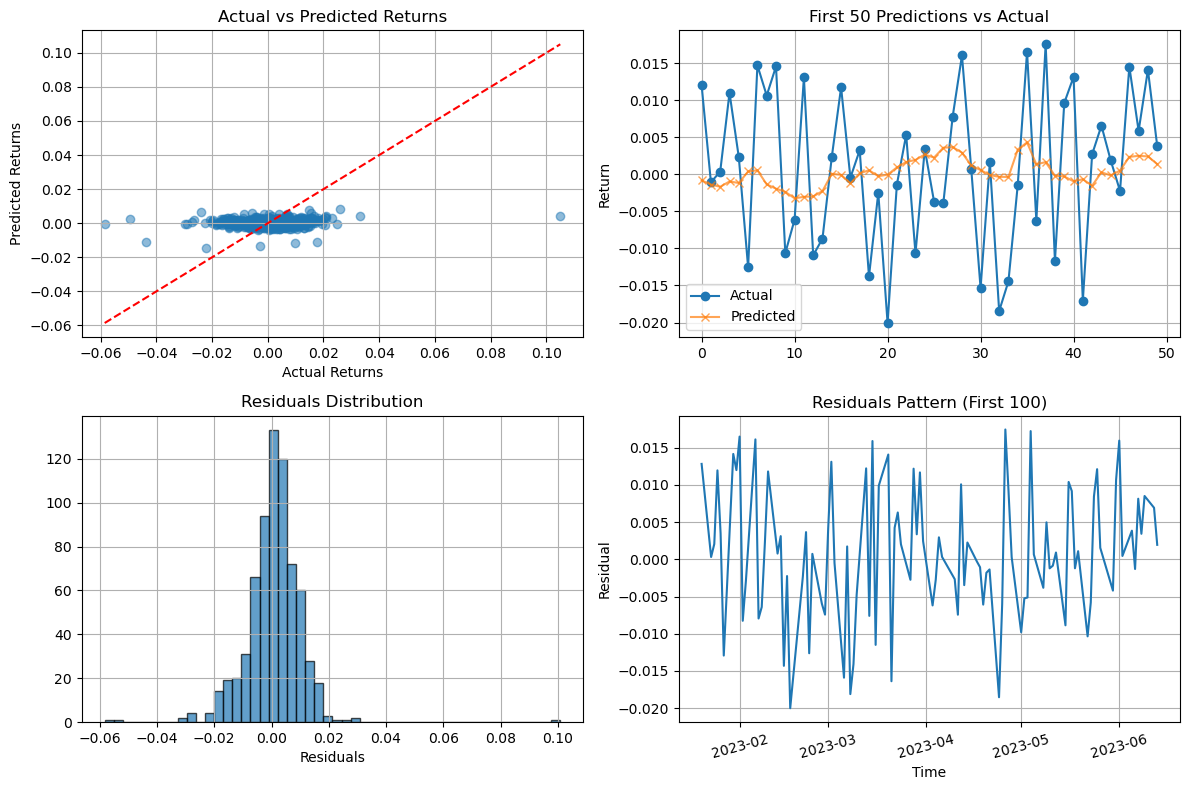


residuals analysis:
residuals mean: 0.000774
residuals std: 0.009704
Check residuals plot for patterns LSTM might learn

--- feature importance (updated features) ---
            feature  coefficient  abs_importance
0     volatility_5d    -0.444011        0.444011
1   volatility_200d     0.242840        0.242840
2    volatility_21d     0.169431        0.169431
3     MA_5_21_ratio    -0.072966        0.072966
4    MA_21_50_ratio    -0.050614        0.050614
5    volatility_50d     0.049471        0.049471
6       momentum_5d    -0.043232        0.043232
7   MA_50_200_ratio    -0.017266        0.017266
8     momentum_200d     0.009392        0.009392
9      momentum_21d     0.008430        0.008430
10     momentum_50d    -0.004378        0.004378
11     volume_ratio     0.000113        0.000113


In [9]:
# visualize results and residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# actual vs predicted (test set)
axes[0,0].scatter(y_test, test_pred, alpha=0.5)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,0].set_xlabel('Actual Returns')
axes[0,0].set_ylabel('Predicted Returns')
axes[0,0].set_title('Actual vs Predicted Returns')
axes[0,0].grid(True)

# time series of predictions (first 50 points)
points_to_plot= min(50, len(y_test))
axes[0,1].plot(y_test.values[:points_to_plot], label='Actual', marker='o')
axes[0,1].plot(test_pred[:points_to_plot], label='Predicted', marker='x', alpha=0.7)
axes[0,1].set_title(f'First {points_to_plot} Predictions vs Actual')
axes[0,1].set_ylabel('Return')
axes[0,1].legend()
axes[0,1].grid(True)

# residuals distribution
axes[1,0].hist(test_residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_title('Residuals Distribution')
axes[1,0].grid(True)

# residuals over time
points_to_plot_res= min(100, len(test_residuals))
axes[1,1].plot(test_residuals.index[:points_to_plot_res], test_residuals.values[:points_to_plot_res])
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Residual')
axes[1,1].set_title(f'Residuals Pattern (First {points_to_plot_res})')
axes[1,1].grid(True)
axes[1,1].tick_params(axis='x', rotation=15)


plt.tight_layout()
plt.show()

print("\nresiduals analysis:")
print(f"residuals mean: {test_residuals.mean():.6f}")
print(f"residuals std: {test_residuals.std():.6f}")
print("Check residuals plot for patterns LSTM might learn")

# feature importance
feature_importance= pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_,
    'abs_importance': np.abs(lr_model.coef_)
}).sort_values('abs_importance', ascending=False).reset_index(drop=True)

print("\n--- feature importance (updated features) ---")
print(feature_importance)

In [10]:
# save results for LSTM
# save residuals and predictions for next notebook

results_dict = {
     'train_residuals': train_residuals,
     'test_residuals': test_residuals,
     'y_test': y_test,
     'linear_test_pred': test_pred,
     'feature_cols': feature_cols,
     'lr_model_coef': lr_model.coef_,
     'lr_model_intercept': lr_model.intercept_
}
import pickle
with open('linear_model_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)
print("\nSaved linear model results to linear_model_results.pkl")

print("\nlinear model updated and ready for LSTM step")


Saved linear model results to linear_model_results.pkl

linear model updated and ready for LSTM step
